In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.linear_model import LinearRegression, Ridge
import plotly.graph_objects as go
import plotly.offline as py
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics.scorer import make_scorer

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

my_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

def generate_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def train_linear_model(X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True, stratify = None,random_state=42)

    regr = LinearRegression()

    regr = regr.fit(X_train,y_train)

    predictions = regr.predict(X_test)

    actual = y_test

    # calculate RMSE
    rmse = math.sqrt(mean_squared_error(actual, predictions))
    print('Test RMSE: %.3f' % rmse)

    pct = mean_absolute_percentage_error(actual,predictions)
    print('MAPE : %.3f' % pct +'%' )
    
    cv_scores = np.abs(cross_val_score(regr, X, y,scoring=my_scorer,cv=25))
   
    print('CV Score :', cv_scores )
    
    print('CV Score Mean:', np.mean(cv_scores))
    
    rmse_percentage = (rmse/y.mean())*100
    print('RMSE Percentage : %.3f' % rmse_percentage +'%' )

    rmse_std = rmse/y.std()
    print('RMSE/STD : %.3f' % rmse_std +'%' )

    fig = go.Figure()
    fig.add_trace(go.Scatter(x = np.arange(0,len(y_train)),
                                     y = y_train['var1(t)'],
                                     mode='lines+markers', name='Train'))
    fig.add_trace(go.Scatter(x = np.arange(len(X_train),len(X_train)+len(actual)),
                                     y = actual['var1(t)'],
                                     mode='lines+markers', name='Actual'))
    fig.add_trace(go.Scatter(x = np.arange(len(X_train),len(X_train)+len(actual)),
                                     y = predictions[:,0],
                                     mode='lines+markers', name='Prediction'))
    fig.update_layout(title="Mean Abs. Pct Error " + '%'+str(round(pct,2)),
                    )
    fig.show()
    return regr

In [76]:
dataset = pd.read_csv('DailyDelhiClimateTest.csv')
dataset.index = pd.to_datetime(dataset.date)
dataset = dataset.drop(columns=['date'])
dataset.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


# Generate a Supervised dataset

In [56]:
reframed = generate_dataset(dataset, 3, 1)

# Check Feature Importance

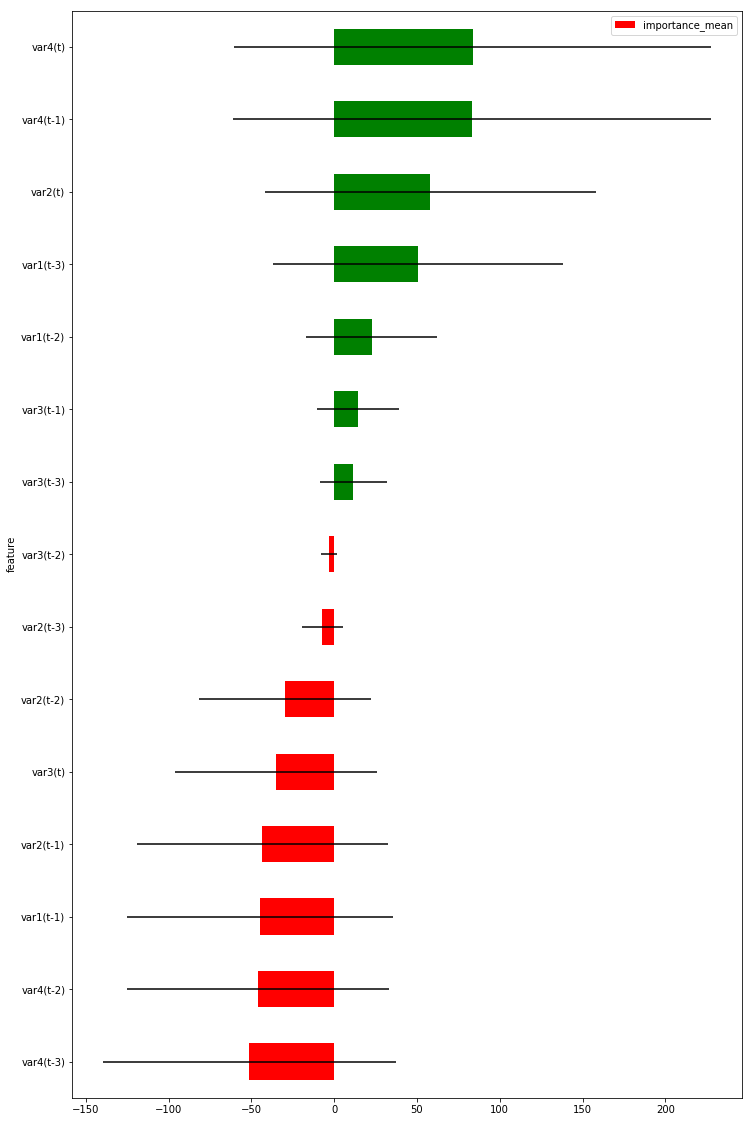

In [57]:
cv = KFold(n_splits=4, shuffle=False, random_state=0)

dataset = Dataset(df=reframed, target="var1(t)", features=[col for col in reframed.columns if col != 'var1(t)'])

model = LinearRegression()

lofo_imp = LOFOImportance(dataset, cv=cv, scoring="neg_mean_squared_error",model = model)

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df, figsize=(12, 20))

In [58]:
features = importance_df.feature.head(8).values
features

array(['var4(t)', 'var4(t-1)', 'var2(t)', 'var1(t-3)', 'var1(t-2)',
       'var3(t-1)', 'var3(t-3)', 'var3(t-2)'], dtype=object)

# Train Model

In [74]:
y = pd.DataFrame(reframed['var1(t)'])

X = pd.DataFrame(reframed[features])

train_linear_model(X,y)

Test RMSE: 1.792
MAPE : 6.672%
CV Score : [ 3.82962767 18.79682811  8.5756442  12.905728    7.43240521  4.52569479
 10.39144142  8.02697863  7.05745828  5.81630388  9.74324828 12.68084323
 13.54233695  5.89656118  7.07866604  8.71398714  5.36559553  6.36046661
  2.26933561  3.41512243  7.29743771  2.42090857  2.02245686  4.37075267
  3.1810667 ]
CV Score Mean: 7.268675827822379
RMSE Percentage : 8.206%
RMSE/STD : 0.280%


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Resampling

In [78]:
resampled = dataset.copy()
#resampled = resampled.resample('W', on="date").mean()  Date = Index, no need to define "on" parameter
resampled = resampled.resample('W').mean()
display(resampled.head())

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-08,17.487247,80.397627,5.061371,1015.048882
2017-01-15,13.191727,73.335438,6.806319,1017.212474
2017-01-22,14.732486,75.707698,9.368017,1020.516354
2017-01-29,17.239193,78.189352,8.815970,1018.575580
